# Proyecto de modelo de regresión lineal

In [142]:
# Importaciones necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

## 1. Cargar del conjunto de datos

In [143]:
# Importando datos
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv', sep=',')
df.head() 

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


## 2. Analisis exploratorio de datos

In [144]:
# Imprimir las dimensiones del dataset
print(df.shape)

(3140, 108)


In [145]:
# Informacion básica de cada columna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


In [146]:
# Comprobar la presencia de filas duplicadas
df.duplicated().sum() 

0

In [147]:
# Valores nulos
df.isnull().sum().sort_values(ascending=False) 

fips                                0
Total nurse practitioners (2019)    0
STATE_NAME                          0
COUNTY_NAME                         0
Percent of Population Aged 60+      0
                                   ..
POP_ESTIMATE_2018                   0
% Two or more races                 0
Two or more races pop               0
% Hawaiian/PI-alone                 0
Urban_rural_code                    0
Length: 108, dtype: int64

In [148]:
# Valores unicos por columna
df.nunique().sort_values(ascending=False)  

fips                                                                      3140
% White-alone                                                             3139
80+ y/o % of total pop                                                    3139
70-79 y/o % of total pop                                                  3139
60-69 y/o % of total pop                                                  3139
                                                                          ... 
CKD_prevalence                                                              43
CKD_Lower 95% CI                                                            39
Active General Surgeons per 100000 Population 2018 (AAMC)                   32
Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)      30
Urban_rural_code                                                             6
Length: 108, dtype: int64

In [149]:
# Identificación de filas duplicadas
df.duplicated().sum()


0

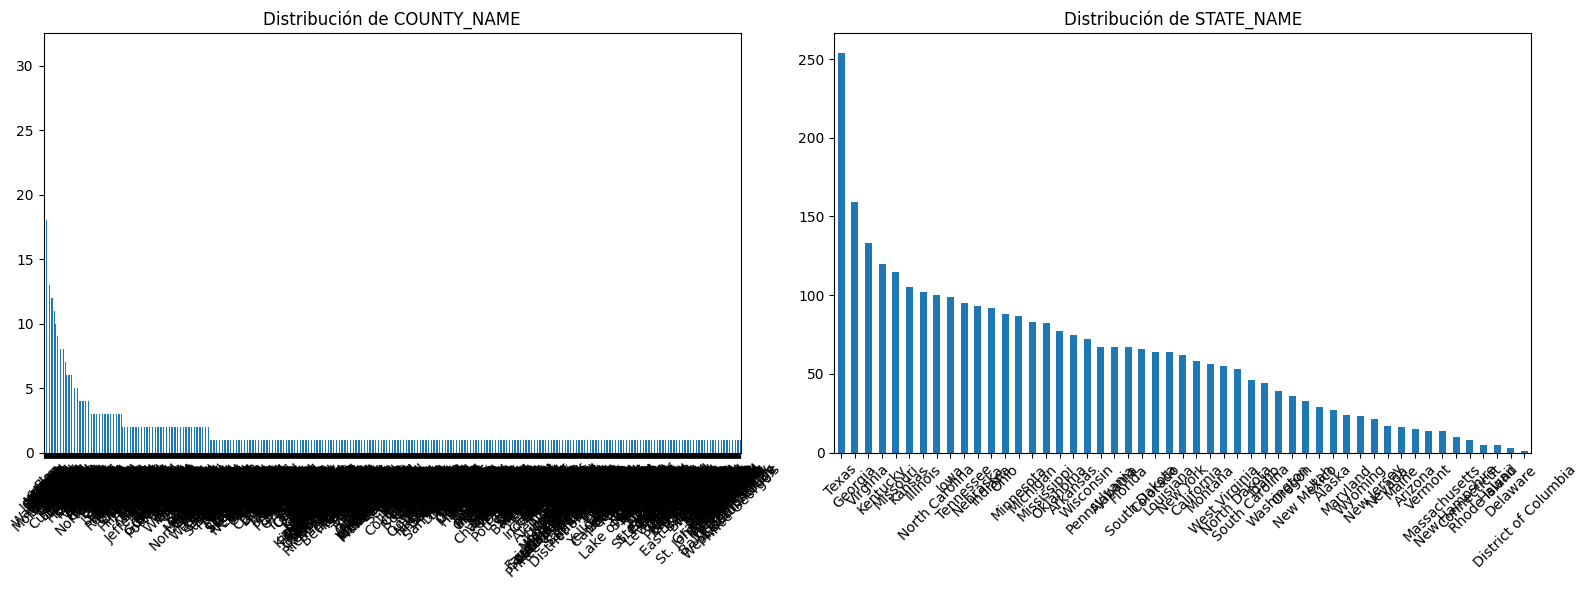

In [150]:
# Seleccionamos columnas categóricas
categorical_cols = df.select_dtypes(include='object').columns

# Creacion de graficas de frecuencia para las columnas que toman valores categoricos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 2 columnas en una fila

for i, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [151]:
# Crear una matriz de correlación absoluta
corr_matrix = df.corr().abs()   

/tmp/ipykernel_1333/3496359063.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr().abs()


In [152]:
# Seleccionar la parte superior de la matriz
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Seleccionamos un umbral
umbral = 0.9

# Encontramos las columnas con correlación mayor al umbral
to_drop = [column for column in upper.columns if any(upper[column] > umbral)]

df_filtrado = df.drop(columns=to_drop)

In [153]:
to_drop

['0-9',
 '19-Oct',
 '20-29',
 '30-39',
 '40-49',
 '50-59',
 '60-69',
 '70-79',
 '80+',
 'White-alone pop',
 'Two or more races pop',
 'POP_ESTIMATE_2018',
 'GQ_ESTIMATES_2018',
 'R_NET_MIG_2018',
 'Less than a high school diploma 2014-18',
 'High school diploma only 2014-18',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or higher 2014-18",
 'POVALL_2018',
 'PCTPOV017_2018',
 'PCTPOV517_2018',
 'CI90LBINC_2018',
 'CI90UBINC_2018',
 'Civilian_labor_force_2018',
 'Employed_2018',
 'Unemployed_2018',
 'Median_Household_Income_2018',
 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)',
 'Total nurse practitioners (2019)',
 'Total physician assistants (2019)',
 'Total Hospitals (2019)',
 'Internal Medicine Primary Care (2019)'

In [154]:
# Validamos el tamaño que ahora tiene el dataset
print(df_filtrado.shape)

(3140, 46)


In [155]:
# Estadistica descrptiva para las columnas numericas
df_filtrado.describe().T 

,count,mean,std,min,25%,50%,75%,max
fips,3140.0,30401.640764,15150.559265,1001.000000,18180.500000,29178.000000,45081.500000,5.604500e+04
TOT_POP,3140.0,104189.412420,333583.395432,88.000000,10963.250000,25800.500000,67913.000000,1.010552e+07
0-9 y/o % of total pop,3140.0,11.871051,2.124081,0.000000,10.594639,11.802727,12.951840,2.546068e+01
10-19 y/o % of total pop,3140.0,12.694609,1.815044,0.000000,11.674504,12.687422,13.659282,2.330437e+01
20-29 y/o % of total pop,3140.0,12.283979,3.126297,0.000000,10.496774,11.772649,13.182260,3.757020e+01
30-39 y/o % of total pop,3140.0,11.751535,1.696599,6.092789,10.689322,11.580861,12.639379,2.222513e+01
40-49 y/o % of total pop,3140.0,11.556685,1.372935,2.631579,10.685197,11.618372,12.386083,1.943037e+01
50-59 y/o % of total pop,3140.0,13.526733,1.481692,5.316361,12.738561,13.621339,14.429115,2.045455e+01
60-69 y/o % of total pop,3140.0,13.182225,2.532498,3.444403,11.621232,13.013409,14.467254,2.727273e+01
70-79 y/o % of total pop,3140.0,8.399382,2.214915,2.199551,7.032275,8.208162,9.445777,3.132796e+01


In [156]:
# Eliminar fips por se un id y COUNTY_NAME por alta cardinalidad (muchos valores únicos con baja frecuencia individual)
df_filtrado = df_filtrado.drop(columns=['fips', 'COUNTY_NAME'])

In [157]:
# Hacer Onehot encoding para STATE_NAME
df_filtrado = pd.get_dummies(df_filtrado, columns=['STATE_NAME'], drop_first=True)

**Observaciones:** 
- los datos conservados hasta este punto no presentan valores nulos, tienen buena variabilidad y se han eliminado los que estan correlacionados entre si, por lo el paso siguiente sería escoger la variable objetivo y con ello, las variables dependientes predictoras.
- La variable objetivo que elijo es: Obesity_prevalence

### Particion de dataset

In [158]:
y = df_filtrado["Obesity_prevalence"]  # Elegimos esta variable objetivo
X = df_filtrado.drop(columns=["Obesity_prevalence"])  # Eliminamos la variable objetivo del set caracteristicas

In [159]:
# Seleccion de las mejores 20 variables en relacion a la variable objetivo
selector = SelectKBest(score_func=f_regression, k=20)
X_selected_array = selector.fit_transform(X, y)
selected_columns = X.columns[selector.get_support()]
X_selected = pd.DataFrame(X_selected_array, columns=selected_columns, index=X.index)

In [160]:
# División en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [161]:
# Valido tamaño de los sets
print(f"Tamaño Train: {X_train.shape}, Tamaño Test: {X_test.shape}")

Tamaño Train: (2512, 20), Tamaño Test: (628, 20)


In [162]:
# Mostrar las mejores características seleccionadas
df_selected = pd.DataFrame({"Variable": selected_columns, "Score": selector.scores_[selector.get_support()]})
df_selected = df_selected.sort_values(by="Score", ascending=False)

In [163]:
print(f"Variables seleccionadas con mayor impacto en la predicción:")
print(df_selected)

Variables seleccionadas con mayor impacto en la predicción:
                                             Variable         Score
14                            anycondition_prevalence  12553.552093
17                                diabetes_prevalence   3004.855896
8   Percent of adults with a bachelor's degree or ...   2948.727947
10                                      MEDHHINC_2018   1748.556413
16                                    COPD_prevalence   1669.686592
15                           Heart disease_prevalence   1428.293382
9                                      PCTPOVALL_2018   1274.725453
7   Percent of adults with a high school diploma o...   1240.942308
6   Percent of adults with less than a high school...   1237.534360
3                                       % Asian-alone    703.612642
4                                        R_death_2018    619.325152
12          Med_HH_Income_Percent_of_State_Total_2018    573.717458
13  Active Physicians per 100000 Population 2018 (...   

In [164]:
# Hacemos escalamiento de las variables seleccionadas para la regresion
escalador = StandardScaler()
X_train_scaled = escalador.fit_transform(X_train)
X_test_scaled = escalador.transform(X_test)

## 3. Constriur el modelo de regresion lineal

### Modelo Lineal estandar

In [165]:
# Crear y entrenar el modelo de regresion lineal
modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)

LinearRegression()

In [166]:
# Hacer las predicciones en el conjunto de prueba y entrenamiento
y_pred_test = modelo.predict(X_test_scaled)
y_pred_train = modelo.predict(X_train_scaled)

In [167]:
# Evaluamos el desempeño en train y test
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"------Train-------")
print(f"Lineal MSE: {mse_train:.2f}")
print(f"Lineal MAE: {mae_train:.2f}")
print(f"Lineal R2: {r2_train:.2f}")
print(f"------Test-------")
print(f"Lineal MSE: {mse_test:.2f}")
print(f"Lineal MAE: {mae_test:.2f}")
print(f"Lineal R2: {r2_test:.2f}")

------Train-------
Lineal MSE: 2.48
Lineal MAE: 1.24
Lineal R2: 0.88
------Test-------
Lineal MSE: 2.52
Lineal MAE: 1.25
Lineal R2: 0.88


**Observaciones:**  
- R² = 0.88 en ambos sets, lo que quiere decir que el modelo explica al 88%  la variable objetivo, siendo un muy buen desempeño para un modelo lineal, ademas, no hay overfitting, el score en test y train son iguales.   
- En cuanto al error cuadratico medio y el error absoluto medio, se nota que son bastante bajos y no tienen mucha variacion entre el conjunto de test y entrenamiento.

In [ ]:
# Validamos los coeficientes del modelo
coef_df = pd.DataFrame({'Feature': X_train.columns,
                        'Coefficient': modelo.coef_}).sort_values(by='Coefficient', key=abs, ascending=False)

coef_df

                                              Feature  Coefficient
14                            anycondition_prevalence     5.198273
15                           Heart disease_prevalence    -1.215476
16                                    COPD_prevalence    -0.931590
3                                       % Asian-alone    -0.356177
19                                STATE_NAME_Colorado    -0.273662
9                                      PCTPOVALL_2018     0.253098
8   Percent of adults with a bachelor's degree or ...    -0.245007
7   Percent of adults with a high school diploma o...     0.152745
18                                   Urban_rural_code     0.142575
5                            R_INTERNATIONAL_MIG_2018     0.124601
13  Active Physicians per 100000 Population 2018 (...    -0.108956
10                                      MEDHHINC_2018     0.101035
6   Percent of adults with less than a high school...    -0.090668
1                                       % White-alone    -0.08

**Observaciones:** 
- Vemos que la variable mas importante es la presencia de alguna otra condicion, la cual favorece a la obesidad, por lo que esa es positiva para este caso.
- Las siguientes cuatro son todas negativas lo que indican que van en contra de la prevalencia de diabetes, incluyen: prevalencia de enfermedades cardiacas, prevalencia de EPOC o o Enfermedad Pulmonar Obstructiva Crónica, poseer genes asiaticos y el estado de colorado como lugar de residencia, de lo cual residir en el estado de colorado y poseer gran porcentaje de genes asiaticos tiene sentido, pero en el caso de la prevalencia de otras enfermedades quizas se deba a que ya que estas personas tienen esas condiciones llevan una dieta estricta de manera preventiva.

### Modelo de regresion lineal Lasso

In [173]:
# Entrenar el modelo Lasso
regresion_lasso = Lasso(alpha=0.1)  
regresion_lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.1)

In [174]:
# Predicciones en el set de prueba
y_pred_lasso = regresion_lasso.predict(X_test_scaled)

In [175]:
# Evaluación del modelo
r2_lasso = r2_score(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

In [176]:
print(f"R² en Test (Lasso): {r2_lasso:.4f}")
print(f"MAE (Lasso): {mae_lasso:.4f}")
print(f"MSE (Lasso): {mse_lasso:.4f}")

R² en Test (Lasso): 0.8647
MAE (Lasso): 1.3007
MSE (Lasso): 2.7945


In [177]:
# Comparación de impacto de alpha en Lasso
alphas = np.arange(0.01, 10, 0.5)
r2_scores_lasso = []
for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha)
    modelo_temp.fit(X_train_scaled, y_train)
    r2_scores_lasso.append(modelo_temp.score(X_test_scaled, y_test))

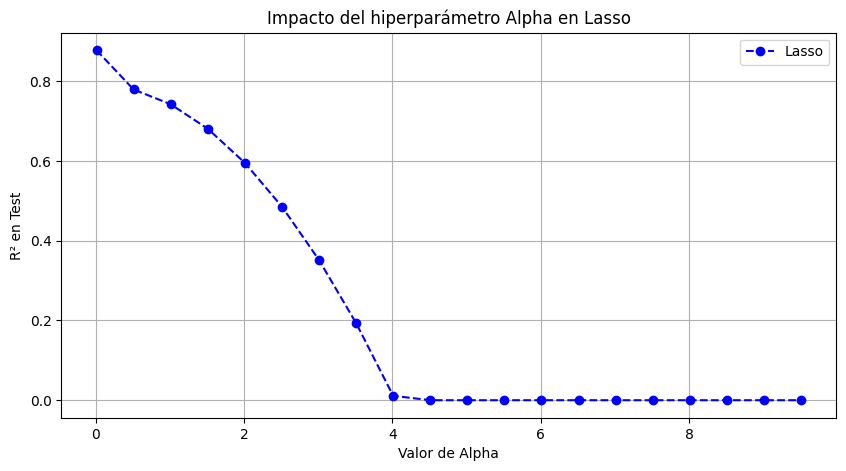

In [188]:
# Representación de los resultados
plt.figure(figsize=(10, 5))
plt.plot(alphas, r2_scores_lasso, marker="o", linestyle="--", color="b", label="Lasso")
plt.xlabel("Valor de Alpha")
plt.ylabel("R² en Test")
plt.title("Impacto del hiperparámetro Alpha en Lasso")
plt.legend()
plt.grid()
plt.show()

In [189]:
# Entrenar el modelo Lasso 2
regresion_lasso2 = Lasso(alpha=0.01)  
regresion_lasso2.fit(X_train_scaled, y_train)

Lasso(alpha=0.01)

In [190]:
# Predicciones en el set de prueba
y_pred_lasso2 = regresion_lasso.predict(X_test_scaled)

In [191]:
# Evaluación del modelo
r2_lasso2 = r2_score(y_test, y_pred_lasso2)
mae_lasso2 = mean_absolute_error(y_test, y_pred_lasso2)
mse_lasso2 = mean_squared_error(y_test, y_pred_lasso2)

In [192]:
print(f"R² en Test (Lasso): {r2_lasso2:.4f}")
print(f"MAE (Lasso): {mae_lasso2:.4f}")
print(f"MSE (Lasso): {mse_lasso2:.4f}")

R² en Test (Lasso): 0.8647
MAE (Lasso): 1.3007
MSE (Lasso): 2.7945


**Observaciones:**
1. En el analisis de el impacto del valor de alpha al coeficiente de determinación, se hace visible que a mayor valor de alpha, es decir penalización, el coeficiente de determinacion disminuye, lo que sugiere que el modelo no requiere penalizacion. 
2. Se tomo la determinacion de aun asi generar otro modelo Lasso optando por un valor de alpha minimo (0.01), pero los resultados siguen siendo los mismos que para el modelo con alpha (0.1), confirmando que el modelo de regresión lineal estandar explica bastante bien la variación de la variable objetivo.
3. De acuerdo a los resultados obtenidos en los valores de el coeficiente de determinación, se determina que el mejor modelo para la prediccion del la prevalencia de diabetes con el set de datos obtenido es el modelo de regresion lineal estandar con un R cuadrado de 0.88 frente a los modelos Lasso con un R cuadrado de 0.86.
4. En ambos casos el MSE y MAE son menores para el modelo de regresion lineal estandar frente al Lasso, por lo cual de confirma que la regularización de Lasso no está aportando ventaja.